## Übungsblatt 4 Machine Learning 1

***Hinweis vorab:*** *Aufgabenstellungen wurden der Übersichtshalber entfernt. Ich hoffe das ist ok, ich fand meine Abgabe erst so wirklich schön.*

<br>**Inhaltsverzeichnis:**

* Vorbereitung (Import, Laden der Daten)
* Data-Understanding (Analyse der Daten)
* Preprocessing (Transformationen)
* Training des Classifier (Wahl des Models, Training über Pipeline)
* Training with Cross Vaildation (10 CV über Pipeline)
* Evaluierung (Accuracy Score, Konfusionsmatrix, ROC-Curve)

### 0. Vorbereitung

**Imports**

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB

**Laden der Daten**

In [2]:
data = pd.read_csv("./DATA/heart.csv")

**Erster Überblick über die Daten:**

In [3]:
print(f"Zeilen: {data.shape[0]}, Spalten: {data.shape[1]}")

Zeilen: 303, Spalten: 14


Nicht allzu viele Feature-Vectors, aber der Naive Bayes kann gut mit kleinen Datensätzen lernen, also alles gut soweit.

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145,233,True,0,150,no,2.3,0,0,1,high risk
1,37,male,2,130,250,False,1,187,no,3.5,0,0,2,high risk
2,41,female,1,130,204,False,0,172,no,1.4,2,0,2,high risk
3,56,male,1,120,236,False,1,178,no,0.8,2,0,2,high risk
4,57,female,0,120,354,False,1,163,yes,0.6,2,0,2,high risk


In [5]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,female,0,140,241,False,1,123,yes,0.2,1,0,3,low risk
299,45,male,3,110,264,False,1,132,no,1.2,1,0,3,low risk
300,68,male,0,144,193,True,1,141,no,3.4,1,2,3,low risk
301,57,male,0,130,131,False,1,115,yes,1.2,1,1,3,low risk
302,57,female,1,130,236,False,0,174,no,0.0,1,1,2,low risk


### 1. Data Understanding(5 Punkte)

*Analysing des Datenstyps und des Encodings wurden an dieser Stelle aus Schönheitsgründen entfernt.*

**Prüfung der Korrelation der Features**, da bei großer Korrelation das Feature doppelt zählen würde und damit eventuell das Ergebnis verfälschen würde.

<AxesSubplot:>

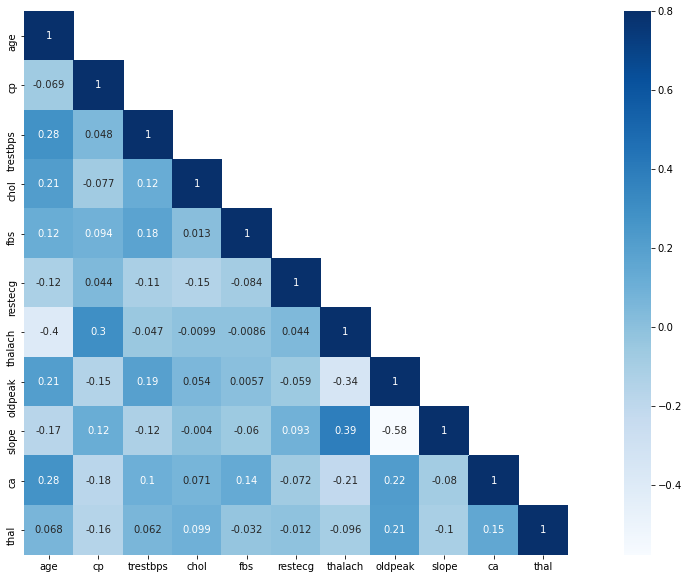

In [6]:
corrMatt = data.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)

sb.heatmap(corrMatt, cmap="Blues", mask=mask,vmax=.8, square=True,annot=True)

Keine sehr hohe Korrelation zu vermerken. -0.58 ist die Höchste, sollte aber wohl noch vernachlässigbar sein.

**Zusammenfassung:**<br>
- sex, fbs, exang und target in Zahlen umwandeln
- trestbps, chol, thalach und oldpeak normalisieren
- eventuell cp und thal OneHotEncoden, aber nicht unbedingt, da dies von Sklearn automatisch erkannt wird

### 2. Preprocessing (14 Punkte)


**Änderung des Encodings:**

In [7]:
label_encoder = LabelEncoder()

data['target'] = label_encoder.fit_transform(data['target'])
    
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145,233,True,0,150,no,2.3,0,0,1,0
1,37,male,2,130,250,False,1,187,no,3.5,0,0,2,0
2,41,female,1,130,204,False,0,172,no,1.4,2,0,2,0
3,56,male,1,120,236,False,1,178,no,0.8,2,0,2,0
4,57,female,0,120,354,False,1,163,yes,0.6,2,0,2,0


Low_Risk = 1, High-Risk = 0 -> Vergleiche mit data.head oben

In [8]:
ord_attributes = ['sex', 'exang', 'fbs']
scale_attributes = ['trestbps', 'chol', 'thalach', 'oldpeak']

prepare_pipeline = ColumnTransformer([
    ("ord", OrdinalEncoder(), ord_attributes),
    ("scale", StandardScaler(), scale_attributes)
])

#prepared = full_pipeline.fit_transform(data)
#prepared

In [9]:
#X = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
X = data.loc[:, data.columns != 'target']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Damit der Algorithmus mit den Features 'sex', 'fbs' und 'exang' arbeiten kann, werden diese in Zahlen umgewandelt. <br>Außerdem muss das 'target'-Feature mit dem dafür vorgesehenen LabelEncoder, ähnlich wie zuvor, in Zahlen umgewandelt werden. <br><br>Auch wenn der NaiveBayes etwas besser, als der Knn, mit den verschiedenen Größen der Features umgehen kann, so ist es eventuell trotzdem sinnvoll quantitative Features zu normalisieren, damit hier aufjedenfall keine Probleme auftreten. Wichtig ist hierbei, dass diese Encodings nicht direkt ausgeführt werden, da sie sonst durch den anderen Datensatz manipuliert sein würden. Beim Normalisieren geht es beispielsweise um min und max-Werte und diese werden bei den Datensätzen (train, test, valid) anders ausfallen und sollten also erst später, auf dem einen Datensatz durchgeführt werden.<br><br>
Zudem wurde dann der Datensatz in Test- und Trainingsdaten eingeteilt. Dabei wurde die Stichprobenstrategie auf Stratify gesetzt, damit auch in jedem Datensatz genügend Feature-Vectors für jede Kategorie zu Verfügung stehen.

### 3. Training des Classifiers (5 Punkte)

**Wahl des Klassifikartors**

Die Wahl des Naive Bayes Klassifikators richtet sich nach den Features. In diesem Fall besitzen wir 4 Normalverteilte Features, 4 Binomialverteilte Features und 5 multinomialverteilte Feature. Aus diesem Grund kann man entweder GaussianNB, MultinomialNB oder BinomialBN wählen. Die Wahl sollte hier keinen großen Unterschied machen.<br>
Bei mir fällt die Wahl auf GaussianNB. Ich denke nämlich , dass die Features hier am wichtigsten für die Klassifikation sind, aber dies ist mehr eine Intuition als eine professionelle Expertise!<br><br>
Hinweis: Normalverteilung der quantitativen Features, wurde zuvor geprüft.

**Training and Scoring**

In [10]:
model_pipe = Pipeline([('preparing', prepare_pipeline),
                        ('training', GaussianNB())])
                         
model_pipe.fit(X_train, y_train)
print(f"Score: {round(model_pipe.score(X_test, y_test)*100, 4)}%")

Score: 75.4098%


Da beim Testen, keine wirklichen Änderungen durch die eh schon sehr wenigen Parameter entstanden sind, habe ich mich für die Standarteinstellungen des Gaussian Naive Bayes belassen.<br><br>
Außerdem wurde Anfangs nur von Trainingsdaten und Testdaten gesprochen, weswegen dies meine Argumentation stüzt.

### 4. Training with Cross Vaildation (4 Punkte)

**Cross-Validation Durchführung:**

In [11]:
from sklearn.model_selection import cross_val_score

result = cross_val_score(model_pipe, X_train, y_train, cv=10)

**Result:**

In [12]:
acc = result[0].mean()
print(f"Accuracy: {round(acc*100, 2)}%")

Accuracy: 72.0%


Wie in der Dokumentation beschrieben, wird hier Stratified Sampling bei einer Integer cv Eingabe verwendet. Was auch sehr wichtig ist, aber das hatte ich ja schon evaluiert.

### 5. Evaluierung (6 Punkte)

**Accuracy-Score:**

In [13]:
pred = model_pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, pred)
print(f"Accuracy: {round(acc*100, 2)}%")

Accuracy: 75.41%


Eindeutig zu gering um diesen Klassifikator in einem so kritischen Anwednungsfall einzusetzen!

**Konfusion-Matrix:**

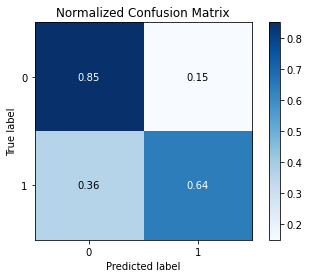

In [14]:
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=True)
plt.show()

Die Konfusions-Matrix zeigt, dass der Klassifikator viele Patienten als Risikopatienten einstuft, obwohl die es gar nicht sind (36%). Das ist aber gar nicht so schlimm, da hier kein wirklich großer Schaden entsteht. Die Patieten stehen wahrscheinlich 'nur' stärker unter Beobachtung. <br>
Der eindeutig fatalere Fall, dass Risikopatienten als risikoarm eingestuft werden, kommt zum Glück nur selten vor. Dieser Punkt kommt dem Klassifikator zu Gute und würde eindeutig für ihn sprechen.

**ROC-Curve:**

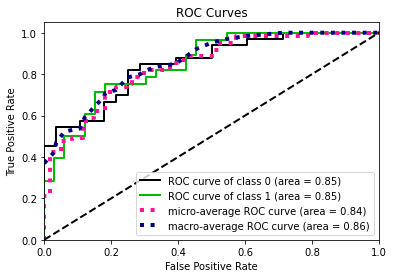

In [15]:
y_probas = model_pipe.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

Zu erwarten war, dass die ROC-Curve der class 0 (High Risk), schlechter abschneidet (sich früher weiter links befindet) als class 1 (low risk). Dies lässt sich aus der Konfusion-Matrix ableiten, da die True-Positive-Rate von class 1 eindeutig geringer ist als die True-Positive-Rate von class 0.<br>
Ein solches Verhältnis ist von der ROC-Curve seltsamerweise jedoch nicht abzulesen. Dies entsteht dadurch, dass die ROC-Curve die True-Positive-Rate in Beziehung mit der False-Positive-Rate angibt. Dadurch wird dieser Fehler sozusagen vertuscht. Zwar werden fast alle Patieten mit hohem Risiko auch mit hohem Risiko klassifiziert, jedoch werden auch viele andere, die gar kein hohes Risiko besitzen mit hohem Risiko klassifiziert. Und genau dadurch ist dieser Unterschied in der ROC-Curve nicht zu erkennen und in der Konfusion-Matrix schon.